In [1]:
from skimage.io import imread
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt
import time
import lib
np.random.seed(1234)

In [2]:
rootfolder = '..'

Useful function for plot the 2D DCT dictionary

In [3]:
def get_dictionary_img(D):
    M, N = D.shape
    p = int(round(np.sqrt(M)))
    nnn = int(np.ceil(np.sqrt(N)))
    bound = 2
    img = np.ones((nnn*p+bound*(nnn-1), nnn*p+bound*(nnn-1)))
    for i in range(N):
        m = np.mod(i, nnn)
        n = int((i-m)/nnn)
        m = m * p + bound * m
        n = n * p + bound * n
        atom = D[:, i].reshape((p, p))
        if atom.min() < atom.max():
            atom = (atom - atom.min()) / (atom.max() - atom.min())
        img[m: m + p, n: n + p] = atom

    return img

Define a function that implements the OMP

In [4]:
# check lib.py

Load the image and rescale it in $[0,1]$

In [5]:
# img = imread(f'{rootfolder}/data/peppers256.png') / 255
# img = imread(f'{rootfolder}/data/barbara.png') / 255
img = imread(f'{rootfolder}/data/Lena512.png') / 255

imsz = img.shape

# patch size
p = 8

# number of elements in the patch
M = p ** 2

Corrupt the image with white gaussian noise

In [6]:
sigma_noise = 20/255
noisy_img = np.random.normal(loc=img, scale=sigma_noise, size=img.shape)
noisy_img.shape

(512, 512)

Percentage of removed pixel

In [7]:
perc_of_removed_pixels = 0.25

Arbitrarily remove pixels setting them to zero

In [8]:
# create a vector with all the indexes of the image
# idx =

# shuffle it and take the target percentage of indexes
#idx =

# the mask is 0 for the chosen idx, 1 elsewhere
# msk =

# apply the mask: set to 0 some elements in the noisy image
# noisy_img =

msk = np.random.binomial(n=1, p=perc_of_removed_pixels, size=img.shape).astype(bool)
noisy_img[msk] = 0

Compute the psnr of the noisy input

In [9]:
psnr_noisy = lib.psnr(img, noisy_img)

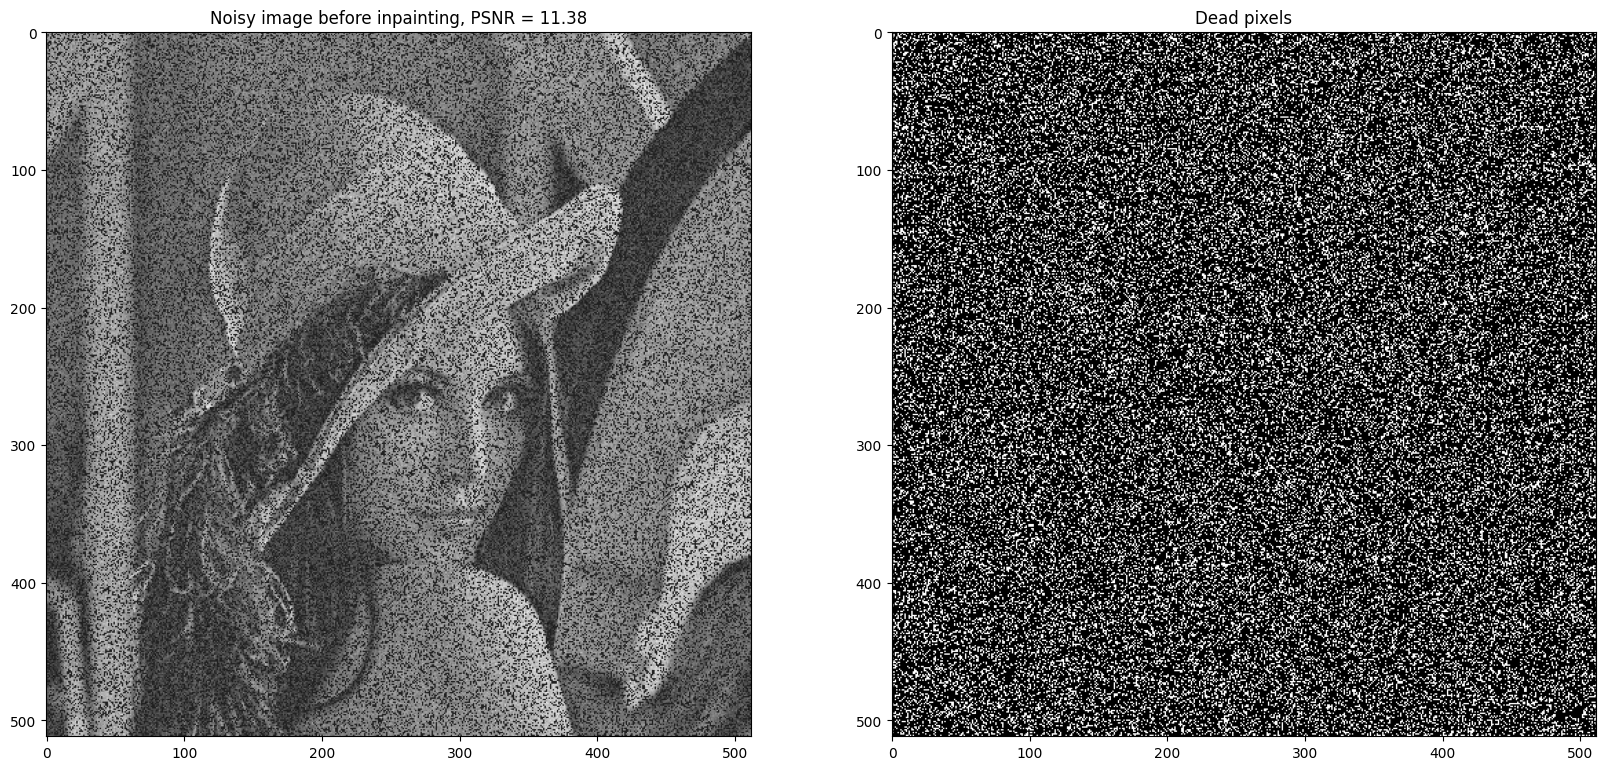

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(noisy_img, cmap='gray')
ax[0].set_title(f'Noisy image before inpainting, PSNR = {psnr_noisy:.2f}')

ax[1].imshow(msk, cmap='gray')
ax[1].set_title(f'Dead pixels');

Load and display the dictionary learned from patches

(64, 256)
(64, 257)


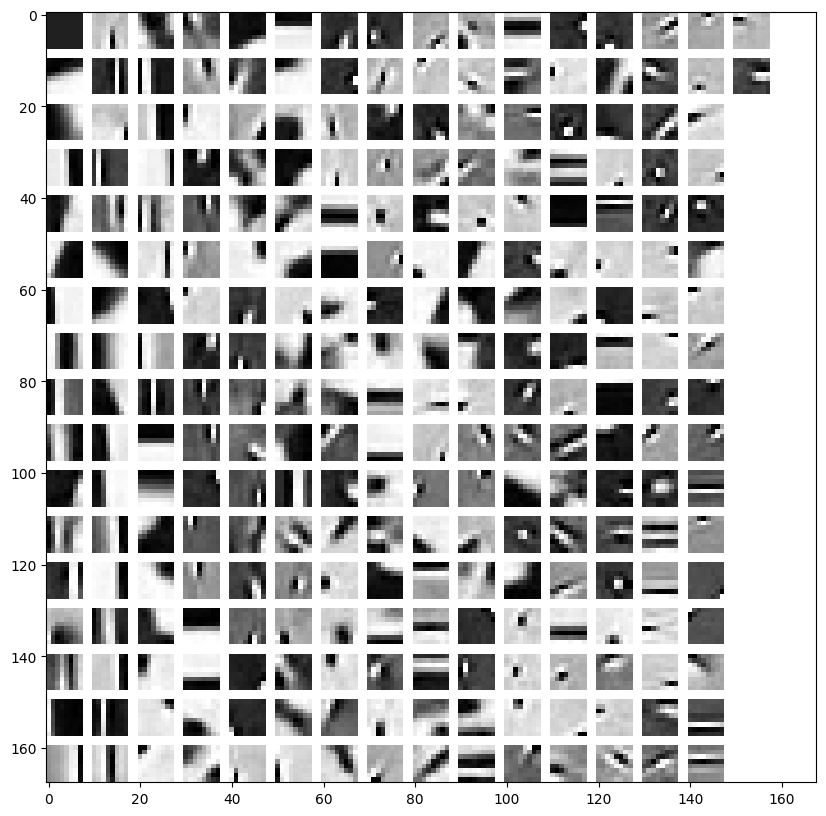

In [11]:
D = loadmat(f'{rootfolder}/data/dict_nat_img.mat')['D']
print(D.shape)

# add a constant atom to D, KSVD was trained over patches with zero mean - and normalize it
D = np.concatenate([np.ones(D.shape[0])[:, None], D], axis=-1)
D = np.stack([di / np.linalg.norm(di) for di in D.T]).T
print(D.shape)

# display the dictionary
D_img = get_dictionary_img(D)

plt.figure(figsize=(10,10))
plt.imshow(D_img, cmap='gray');

Inpainting
----------


In [12]:
# SET stopping criteria of OMP
# orthogonal matching pursuit uses sparsity and errors as stopping criteria
L = M / 2

# initialize the estimated image
img_hat = np.zeros_like(img)

# initialize the weight matrix
weights = np.zeros_like(img)

# define the step (=p for non overlapping paches)
STEP = 4 

# STEP = 1 might be very time consuming, start with larger STEP

Operate patchwise

In [13]:
for i in range(0, imsz[0] - p + 1, STEP):
    for j in range(0, imsz[1] - p + 1, STEP):
        # extrach the patch with the top left corner at pixel (ii, jj)
        s = noisy_img[i:i+p, j:j+p].flatten()

        # patch extracted from the mask
        m = msk[i:i+p, j:j+p].flatten()

        # tau should be proportional to the number of pixels remaining in the patch
        # tau = 6e-2 * (1 - perc_of_removed_pixels) * p ** 2
        tau = 1.15 * sigma_noise * np.sqrt(np.sum((~m).astype(int)))

        # sparse coding w.r.t. PD the inpainted dictionary using L and tau as stopping criteria
        PD = D.copy()
        PD[m, :] = 0
        # Alternatively:
        # proj = np.diag(1 - m)
        # PD = proj @ D
        # x = lib.OMP_good(s, PD, L, tau, False)
        x = lib.OMP(s, PD, L, tau, normalize_dict=False)

        # reconstruction: synthesis w.r.t. D the dictionary yielding sparse representation
        s_hat = D @ x

        # use uniform weights for aggregation
        w = 1

        # put the denoised patch into the estimated image using uniform weights
        # UPDATE img_hat
        img_hat[i:i+p, j:j+p] += s_hat.reshape(p, p)

        # store the weight of the current patch in the weight matrix
        # UPDATE weights
        weights[i:i+p, j:j+p] += w

Normalize the estimated image with the computed weights

In [14]:
img_hat = img_hat / weights

Compute the psnr of the estimated image

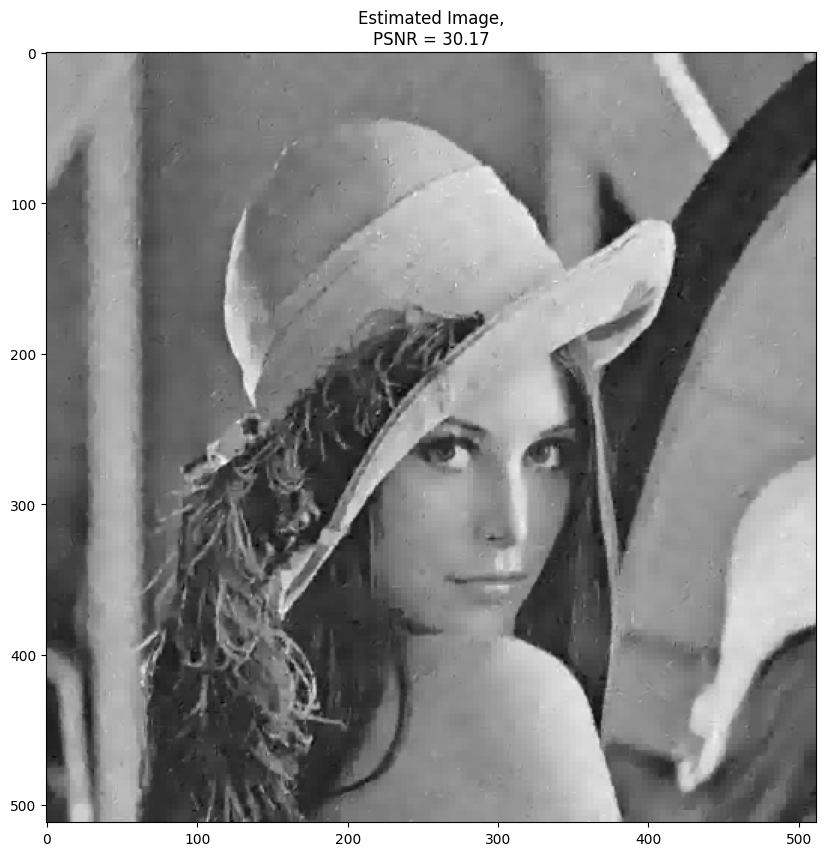

In [15]:
psnr_hat = -10 * np.log10(np.mean((img - img_hat) ** 2))
plt.figure(figsize=(10,10))
plt.imshow(img_hat, cmap='gray')
plt.title(f'Estimated Image,\nPSNR = {psnr_hat:.2f}');